# Deep Reinforcement learning - Training an Agent to Solve Unity-ML Reacher environment using DDPG algorithm

---

This notebook presents the code to train a Deep RL Agent to solve the Unity ML Reacher Environment. The training uses Deep Deterministic Policy Gradient algorithm
The Reacher environment consists of 20 identical agents.

### 1. Import the packages & Start the Environment

In [1]:
from unityagents import UnityEnvironment
import numpy as np
import random
import torch
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

from deep_rl.agent.DDPG_agent import DDPGAgent

In [2]:
# Twenty identical Agent version of the environment app (Mac version) has been used. 
# Environment app downloaded from https://s3-us-west-1.amazonaws.com/udacity-drlnd/P2/Reacher/Reacher.app.zip
env = UnityEnvironment(file_name = "Reacher_twenty_agents.app")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_size -> 5.0
		goal_speed -> 1.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


## 3. Training

In [5]:
# create a new agent
agent = DDPGAgent(state_size=brain.vector_observation_space_size, action_size=brain.vector_action_space_size, random_seed=2)

In [6]:
def train_ddpg(n_episodes=500, max_t=3000, print_every=100):
    scores_deque = deque(maxlen=print_every)
    scores = []
    noise_factor = 0.1  # A factor to multiply random noise
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        scores_agents = np.zeros(20)  # the scores of all 20 reacher agents after an episode
        agent.reset()
        for t in range(max_t):
            # The Agent selects Actions
            actions = agent.act(states, noise_factor=noise_factor)
            
            # Environment processes the Action; produces new State, Rewards
            env_info = env.step(actions)[brain_name]      
            rewards = env_info.rewards                    
            next_states = env_info.vector_observations    
            dones = env_info.local_done 
            
            # The Agent learns
            agent.step(states, actions, rewards, next_states, dones)
            
            states = next_states
            scores_agents += rewards
            if np.any(dones):
                break 
        avg_score = np.mean(scores_agents)  # the average score of the agents
        scores_deque.append(avg_score)
        scores.append(avg_score)
        
        #noise reduced during training as episodes progresses
        noise_factor = max(0.995 * noise_factor, 0.01)
        
        print('\rEpisode {:d}\tscore: {:.2f}\taverage score over the last 10 episodes: {:.2f}'.format(i_episode, scores_deque[-1], np.mean(list(scores_deque)[-10:])), end="")
        #if i_episode % 10 == 0:
            #torch.save(agent.actor_local.state_dict(), 'weights/checkpoint_actor_{:d}_{:.2f}.pth'.format(i_episode, scores_deque[-1]))
            #torch.save(agent.critic_local.state_dict(), 'weights/checkpoint_critic_{:d}_{:.2f}.pth'.format(i_episode, scores_deque[-1]))
        if i_episode > 100 and np.mean(scores_deque) > 30:
            torch.save(agent.actor_local.state_dict(), 'weights/checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'weights/checkpoint_critic.pth')
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_deque)))
            break
        if i_episode % print_every == 0:
            torch.save(agent.actor_local.state_dict(), 'weights/checkpoint_actor_{:d}_{:.2f}.pth'.format(i_episode, scores_deque[-1]))
            torch.save(agent.critic_local.state_dict(), 'weights/checkpoint_critic_{:d}_{:.2f}.pth'.format(i_episode, scores_deque[-1]))
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
            
    return scores

scores = train_ddpg()


Episode 100	Average Score: 1.49 score over the last 10 episodes: 3.39
Episode 200	Average Score: 14.78 score over the last 10 episodes: 27.88
Episode 282	score: 30.64	average score over the last 10 episodes: 31.57
Environment solved in 182 episodes!	Average Score: 30.05


In [7]:
#Close the environment
env.close()

## 4. Plot Score vs Episode#

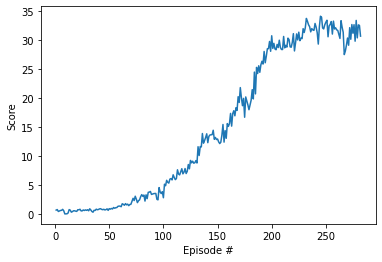

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()